In [153]:
import json
import os
import pandas as pd

import math


In [7]:
#open file

fileList = os.listdir("data")

#fileList
f = open("data/"+fileList[0])

data = json.load(f)

In [ ]:
#Can't read pandas directly, unstrucutred messed of a file
#pdData = pd.read_json("data/"+fileList[0])

In [23]:
type(data.keys())

a = set([1,2,3])

In [71]:
k = 
k

{'highPrice',
 'lastPrice',
 'lowPrice',
 'openInterest',
 'openPrice',
 'percentChange',
 'priceChange',
 'tradeTime',
 'volume'}

In [120]:
sample = data["data"]
dfKeys = set(sample[0].keys()).difference({"raw"})
#Maybe don't set-ify an ordered collenction
df = pd.DataFrame(sample, columns=list(dfKeys))

In [121]:
df

,openInterest,lastPrice,percentChange,tradeTime,priceChange,openPrice,lowPrice,highPrice,volume
0,0,"1,451.50",-0.51%,03/17/2000,-7.50,"1,461.75","1,451.50","1,465.00",0
1,0,"1,459.00",+4.57%,03/16/2000,+63.75,"1,396.00","1,395.75","1,469.00",0
2,0,"1,395.25",+2.42%,03/15/2000,+33.00,"1,361.75","1,356.75","1,398.75",0
3,0,"1,362.25",-1.54%,03/14/2000,-21.25,"1,380.25","1,359.50","1,395.75",0
4,0,"1,383.50",-1.14%,03/13/2000,-16.00,"1,398.00","1,364.75","1,415.75",0
...,...,...,...,...,...,...,...,...,...
59,0,"1,458.25",+0.26%,12/22/1999,+3.75,"1,454.25","1,445.25","1,458.25",0
60,0,"1,454.50",+1.36%,12/21/1999,+19.50,"1,434.25","1,430.50","1,456.25",0
61,0,"1,435.00",-0.66%,12/20/1999,-9.50,"1,441.50","1,429.25","1,448.75",0
62,0,"1,444.50",+0.47%,12/17/1999,+6.75,"1,437.50","1,434.75","1,450.75",0


In [122]:
#Lazy conversion on my end, could've used locales
#str -> specify non total item replacement
df["lastPrice"] = df["lastPrice"].str.replace(",","").astype("float64")

In [126]:
df["tradeTime"] = df["tradeTime"].apply(pd.to_datetime)

,openInterest,lastPrice,percentChange,tradeTime,priceChange,openPrice,lowPrice,highPrice,volume
0,0,1451.50,-0.51%,2000-03-17,-7.50,"1,461.75","1,451.50","1,465.00",0
1,0,1459.00,+4.57%,2000-03-16,+63.75,"1,396.00","1,395.75","1,469.00",0
2,0,1395.25,+2.42%,2000-03-15,+33.00,"1,361.75","1,356.75","1,398.75",0
3,0,1362.25,-1.54%,2000-03-14,-21.25,"1,380.25","1,359.50","1,395.75",0
4,0,1383.50,-1.14%,2000-03-13,-16.00,"1,398.00","1,364.75","1,415.75",0
...,...,...,...,...,...,...,...,...,...
59,0,1458.25,+0.26%,1999-12-22,+3.75,"1,454.25","1,445.25","1,458.25",0
60,0,1454.50,+1.36%,1999-12-21,+19.50,"1,434.25","1,430.50","1,456.25",0
61,0,1435.00,-0.66%,1999-12-20,-9.50,"1,441.50","1,429.25","1,448.75",0
62,0,1444.50,+0.47%,1999-12-17,+6.75,"1,437.50","1,434.75","1,450.75",0


In [128]:
df.dtypes

openInterest             object
lastPrice               float64
percentChange            object
tradeTime        datetime64[ns]
priceChange              object
openPrice                object
lowPrice                 object
highPrice                object
volume                   object
dtype: object

In [36]:
import seaborn

In [49]:
#sample = [(x["tradeTime"],x["lastPrice"]) for x in data["data"]]

,openInterest,lastPrice,percentChange,tradeTime,priceChange,openPrice,lowPrice,highPrice,volume
0,0,"1,451.50",-0.51%,03/17/2000,-7.50,"1,461.75","1,451.50","1,465.00",0


Text(0, 0.5, 'Last Price')

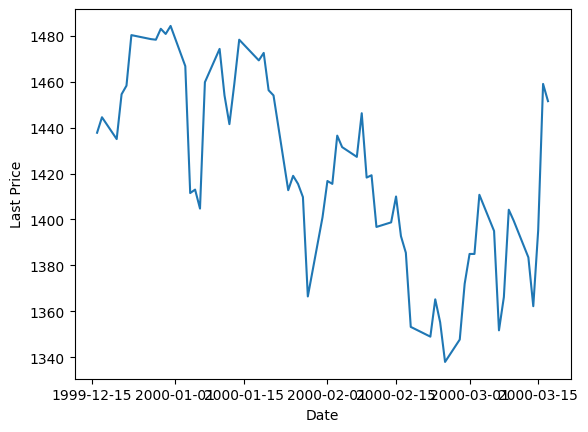

In [129]:
ss = seaborn.lineplot(x="tradeTime", y="lastPrice", data=df)
ss.set_xlabel("Date")
ss.set_ylabel("Last Price")

In [140]:
max(df["tradeTime"])-min(df["tradeTime"])

Timedelta('92 days 00:00:00')

0         NaN
1     1451.50
2     1459.00
3     1395.25
4     1362.25
       ...   
59    1480.25
60    1458.25
61    1454.50
62    1435.00
63    1444.50
Name: lastPrice, Length: 64, dtype: float64

In [183]:
logRets = (df["lastPrice"].shift(1)[1:]/df["lastPrice"][1:]).apply(math.log)

In [189]:
df["logReturns"] = logRets
#Indexes are kept throughout series!

In [190]:
df


,openInterest,lastPrice,percentChange,tradeTime,priceChange,openPrice,lowPrice,highPrice,volume,logReturns
0,0,1451.50,-0.51%,2000-03-17,-7.50,"1,461.75","1,451.50","1,465.00",0,NaN
1,0,1459.00,+4.57%,2000-03-16,+63.75,"1,396.00","1,395.75","1,469.00",0,-0.005154
2,0,1395.25,+2.42%,2000-03-15,+33.00,"1,361.75","1,356.75","1,398.75",0,0.044678
3,0,1362.25,-1.54%,2000-03-14,-21.25,"1,380.25","1,359.50","1,395.75",0,0.023936
4,0,1383.50,-1.14%,2000-03-13,-16.00,"1,398.00","1,364.75","1,415.75",0,-0.015479
...,...,...,...,...,...,...,...,...,...,...
59,0,1458.25,+0.26%,1999-12-22,+3.75,"1,454.25","1,445.25","1,458.25",0,0.014974
60,0,1454.50,+1.36%,1999-12-21,+19.50,"1,434.25","1,430.50","1,456.25",0,0.002575
61,0,1435.00,-0.66%,1999-12-20,-9.50,"1,441.50","1,429.25","1,448.75",0,0.013497
62,0,1444.50,+0.47%,1999-12-17,+6.75,"1,437.50","1,434.75","1,450.75",0,-0.006598


In [188]:
logRets

1    -0.005154
2     0.044678
3     0.023936
4    -0.015479
5    -0.011499
        ...   
59    0.014974
60    0.002575
61    0.013497
62   -0.006598
63    0.004684
Name: lastPrice, Length: 63, dtype: float64

<Axes: ylabel='lastPrice'>

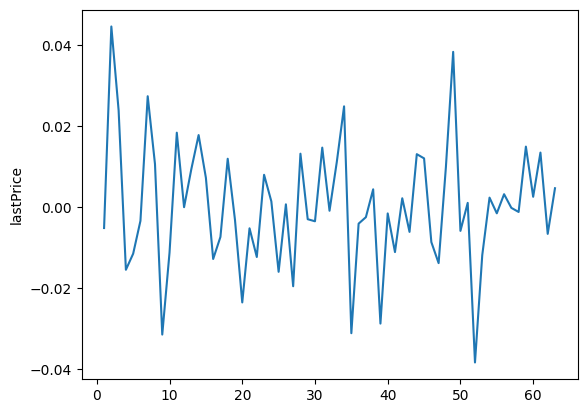

In [176]:
seaborn.lineplot(logRets)

In [185]:
print(type(logRets))
logRets = pd.Series(logRets)
print(type(logRets))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [17]:
for i in data["data"]:
    print(i["lastPrice"])

1,451.50
1,459.00
1,395.25
1,362.25
1,383.50
1,399.50
1,404.25
1,366.25
1,351.75
1,395.00
1,410.75
1,385.00
1,385.00
1,372.00
1,347.75
1,338.00
1,355.25
1,365.25
1,349.00
1,353.25
1,385.50
1,392.75
1,410.00
1,398.75
1,396.75
1,419.25
1,418.25
1,446.25
1,427.25
1,431.50
1,436.50
1,415.50
1,416.75
1,401.00
1,366.50
1,409.75
1,415.50
1,419.00
1,412.75
1,454.00
1,456.25
1,472.50
1,469.25
1,478.25
1,459.00
1,441.50
1,454.00
1,474.25
1,459.75
1,404.75
1,413.00
1,411.50
1,466.75
1,484.25
1,480.75
1,483.00
1,478.25
1,478.50
1,480.25
1,458.25
1,454.50
1,435.00
1,444.50
1,437.75
